# Summarize CHM results from DINOv3 for CAVM 100km buffer in Alaska - read and plot

#### Workflow steps: 
1.  `cavm_buffer_above_shrubs.ipynb` --> creates the AOI needed for mosaic
2.  `mosaic_chm_dinvo3.ipynb` --> creates a tiles mosaic of CHM data with masking within AOI
3.  `summarize_chm_dinov3_create.ipynb` --> computes height class summary table
4.  `summarize_chm_dinov3_plot.ipynb` --> uses height class smry to plot bar/donut plot
5.  `map_chm_dinov3.ipynb` --> map corresponding to data plotted from summary

Paul Montesano  
Feb 2026

In [8]:
# # Add your personal library to the BEGINNING of the search path
# .libPaths(c("/panfs/ccds02/home/pmontesa/R/my_packages", .libPaths()))

# .libPaths()

# dir.exists("~/R/my_packages")

# # Check actual path (~ expansion)
# normalizePath("~/R/my_packages", mustWork = FALSE)

# install.packages("ggrepel", lib = "/panfs/ccds02/home/pmontesa/R/my_packages", verbose = TRUE)

# # Redirect stderr to see compilation/installation errors
# install.packages("ggrepel", 
#                  lib = "/panfs/ccds02/home/pmontesa/R/my_packages",
#                  repos = "https://cloud.r-project.org/",
#                  INSTALL_opts = c("--no-test-load"))

# # See where a specific package is installed
# find.package("ggrepel")

# list.files("/panfs/ccds02/home/pmontesa/R/my_packages", all.files = TRUE)

In [13]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(data.table)
library(patchwork)

#### The portion of the 100km CAVM buffer AOI that we mapped

#### Need all 103 tiles the cover CAVM 100km buffer zone to get accurate Pct area mapped 

#### Functions

In [2]:
library(ggrepel)

In [3]:
library(grDevices)

# Create 12 evenly spaced colors from your palette
forest_ht_colors <- c('#636363','#fc8d59','#fee08b','#ffffbf',
                      '#d9ef8b','#91cf60','#1a9850','#005a32')

forest_ht_colors_12 <- colorRampPalette(forest_ht_colors)(12)

# # View them
# library(scales)
# show_col(forest_ht_colors_12)

In [4]:
calc_area_stats <- function(area_stats){
    # Calculate total valid area
    total_area_km2 <- sum(area_stats$total_valid_area_km2)
    total_area_aoi_km2 = sum(area_stats$total_area_aoi_km2)
    pct_AOI_mapped = round(100 * (sum(area_stats$total_valid_area_km2) / sum(area_stats$total_area_aoi_km2)), 1)
    n_files <- nrow(area_stats)
    
    cat(sprintf("Total valid area: %s km²\n", format(round(total_area_km2), big.mark = ",")))
    cat(sprintf("Total AOI area: %s km²\n", format(round(total_area_aoi_km2), big.mark = ",")))
    cat(sprintf("Proportion of AOI mapped: %f %%\n", pct_AOI_mapped))
    cat(sprintf("Number of files: %d\n", n_files))
    
    # Use in plot subtitle
    subtitle <- sprintf("Based on %d tiles covering %s km² (%s)",
                        n_files,
                        format(round(total_area_km2), big.mark = ","),
                       MOSAIC_SUBDIR)
    
    # Reshape to long format
    area_long <- area_stats %>%
      select(file, starts_with('area_')) %>%
      pivot_longer(
        cols = starts_with('area_'),
        names_to = "height_class",
        values_to = "area_km2",
        names_prefix = "area_"
      ) %>%
      filter(height_class != 'total_valid_area_km2')
    
    # Extract numeric values
    area_long <- area_long %>%
      mutate(
        height_lower = as.numeric(gsub("([0-9.]+)-.*", "\\1", height_class))
      )
    
    # Combine 10-20m and 20-50m into ">10m"
    area_long <- area_long %>%
      mutate(
        height_class_combined = case_when(
          height_lower >= 5 ~ ">5m",
          TRUE ~ height_class
        ),
        # Update height_lower for combined class
        height_lower_combined = ifelse(height_lower >= 5, 5, height_lower)
      )
    
    # Aggregate combined classes
    area_long_combined <- area_long %>%
      group_by(file, height_class_combined, height_lower_combined) %>%
      summarise(area_km2 = sum(area_km2), .groups = 'drop')
    
    # Create ordered factor
    area_long_combined <- area_long_combined %>%
      mutate(
        height_class_combined = factor(height_class_combined, 
                                       levels = unique(height_class_combined[order(height_lower_combined)]))
      )
    return(list(area_long_combined, pct_AOI_mapped))
    }

In [5]:
do_bootstrap_ci <- function(area_long_combined){
    # Bootstrap and summarize
    
    # STEP 1: Define bootstrap_ci function FIRST
    bootstrap_ci <- function(x, n_boot = 1000, conf = 0.95) {
      boot_totals <- replicate(n_boot, {
        sample_idx <- sample(length(x), replace = TRUE)
        sum(x[sample_idx])
      })
      
      total <- sum(x)
      ci_lower <- quantile(boot_totals, (1 - conf) / 2)
      ci_upper <- quantile(boot_totals, 1 - (1 - conf) / 2)
      
      return(data.frame(
        total = total,
        ci_lower = ci_lower,
        ci_upper = ci_upper
      ))
    }
    
    area_summary <- area_long_combined %>%
      group_by(height_class_combined, height_lower_combined) %>%
      summarise(
        bootstrap_ci(area_km2, n_boot = 1000, conf = 0.95),
        .groups = 'drop'
      ) %>%
      mutate(
        ci_half_width = (ci_upper - ci_lower) / 2,
        total_formatted = format(round(total), big.mark = ","),
        ci_formatted = paste0("±", format(round(ci_half_width), big.mark = ","))#,
        #height_for_color = pmin(height_lower_combined, 5)
      )
    return(area_summary)
    }

In [6]:
calc_totals_and_plot <- function(area_stats, area_summary, pct_AOI_mapped, forest_ht_cmap, total_chms_used=''){
    
    # Calculate totals
    total_area_km2 <- sum(area_stats$total_valid_area_km2)
    n_files <- nrow(area_stats)
    
    
    
    # Plot with forest height colormap
    p <- ggplot(area_summary, aes(x = height_class_combined, y = total, fill = height_for_color)) +
      geom_col(alpha = 0.9, color = "black") +
      scale_fill_gradientn(
        colors = forest_ht_cmap,
        limits = c(0, 5),
        oob = scales::squish,
        guide = "none"
      ) +
      geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), 
                    width = 0.05, linewidth = 1) +
      geom_label(aes(label = paste0(total_formatted, " km²\n", ci_formatted)),
                vjust = -0.5, 
                 size = 3.25, 
                 fontface = "bold", color = "black", fill="white", alpha=0.75) +
      labs(
          title = sprintf("Vegetation heights across %.1f %% of biome boundary in Alaska", pct_AOI_mapped),
        #title = sprintf("Vegetation heights across %.1f %% of 100km CAVM buffer in Alaska", pct_AOI_mapped),
        subtitle = sprintf(#"From %d commercial VHR acquisitions (%s) covering %s km²",
                            "From %s commercial VHR acquisitions covering %s km² of 100 km buffer of treeline",
                           #n_files,
            total_chms_used,
            format(round(total_area_km2), big.mark = ",")
        
        ),
        x = "Vegetation height class",
        y = "Total Area (km²)",
          caption = MOSAIC_SUBDIR
      ) +
      scale_y_continuous(labels = scales::comma, expand = expansion(mult = c(0, 0.15))) +
      theme_bw(base_size = 12) +
      theme(
        axis.text.x = element_text(angle = 0, hjust = 0.5),
        plot.title = element_text(face = "bold"),
        panel.grid.major.x = element_blank()
      )

    # Calculate proportions
    area_summary <- area_summary %>%
      mutate(
        proportion = total / sum(total),
        pct = round(proportion * 100, 1),
        pct_label = paste0(height_class_combined, "\n", pct, "%")
      )
    
    # Create donut plot with centered title
    p_donut <- ggplot(area_summary, aes(x = 2, y = total, fill = height_for_color)) +
      geom_col(color = "white", linewidth = 1, position = "stack") +
      # geom_text(aes(label = pct_label), 
      #           position = position_stack(vjust = 0.5),
      #           color = "black", fontface = "bold", size = 2.5) +
  geom_label_repel(
    aes(label = pct_label),
    stat = "identity",
    position = position_stack(vjust = 0.25),
    color = "black", 
    fontface = "bold", 
    size = 3.5,
    box.padding = 0.5,
    label.padding = 0.2,
    segment.color = "black",
    segment.size = 0.3,
    min.segment.length = 0,
    direction = "both",
    force = 2,
    max.overlaps = Inf
  ) +
      annotate("text", x = 0.5, y = 0.5, 
               label = "Proportion by\nheight class", 
               size = 4, fontface = "bold", hjust = 0.5, vjust = 0.5) +  # Center text
      coord_polar(theta = "y", start = pi) +
      xlim(c(0.5, 2.5)) +
      scale_fill_gradientn(
        colors = forest_ht_cmap,
        limits = c(0, 5),
        oob = scales::squish,
        guide = "none"
      ) +
      theme_void()
    
    # Combine with bar plot
    combined <- p + 
      inset_element(p_donut, 
                    left = 0.1, bottom = 0.25,
                    right = 1.2, top = 1.05)
    
    return(list(combined, p, p_donut))
    }

### Loop over various output mosaics made for with 100 km CAVM buffer in Alaska

should be 103 mosaic 90km2 tiles associated with this extent 

In [14]:
DIR_PAPER_FIGS
NAME_STEM
MOSAIC_SUBDIR

[1] "/explore/nobackup/projects/above/misc/ABoVE_Shrubs/paper_figs"

[1] "cavm100km_alaska_chm_002m"

[1] "002m_mos_2018_212_deltayr8_months78_10m"

In [19]:
area_stats <- fread(paste0(DIR_PAPER_FIGS,'/', NAME_STEM, '_height_class_area_',MOSAIC_SUBDIR,'.csv'))
dim(area_stats)

[1] 103  25

[1] "002m_mos_2018_212_deltayr8_months789_10m"
Total valid area: 275,179 km²
Total AOI area: 549,734 km²
Proportion of AOI mapped: 50.100000 %
Number of files: 103
[1] 7 9
[1] "002m_mos_2018_212_deltayr8_months78_10m"
Total valid area: 220,977 km²
Total AOI area: 549,734 km²
Proportion of AOI mapped: 40.200000 %
Number of files: 103
[1] 7 9


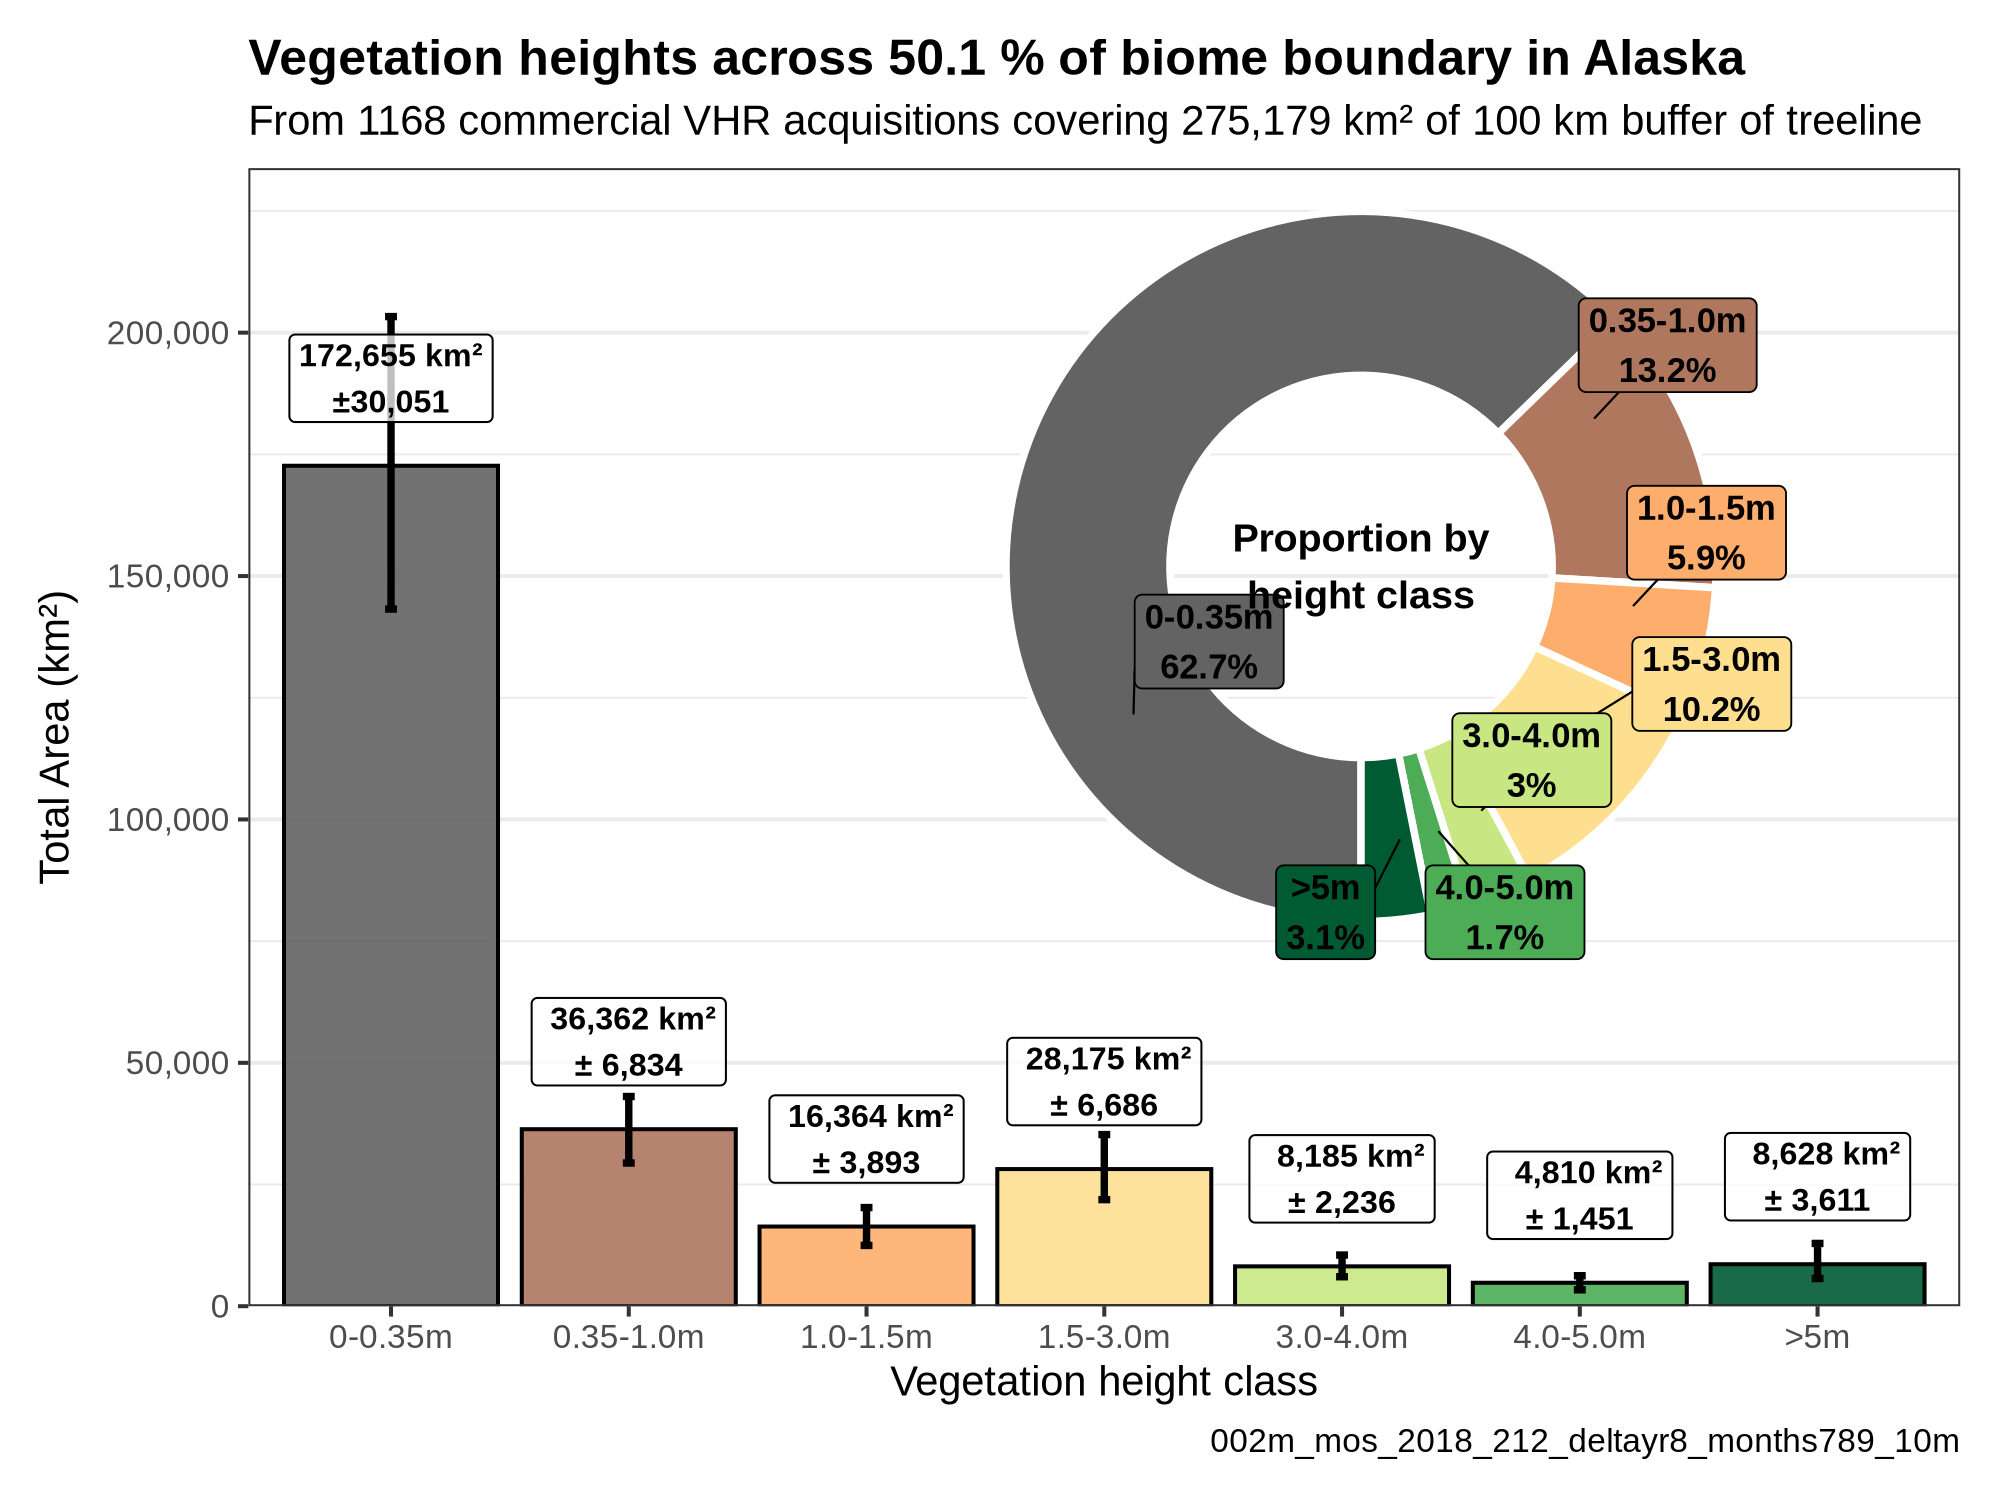

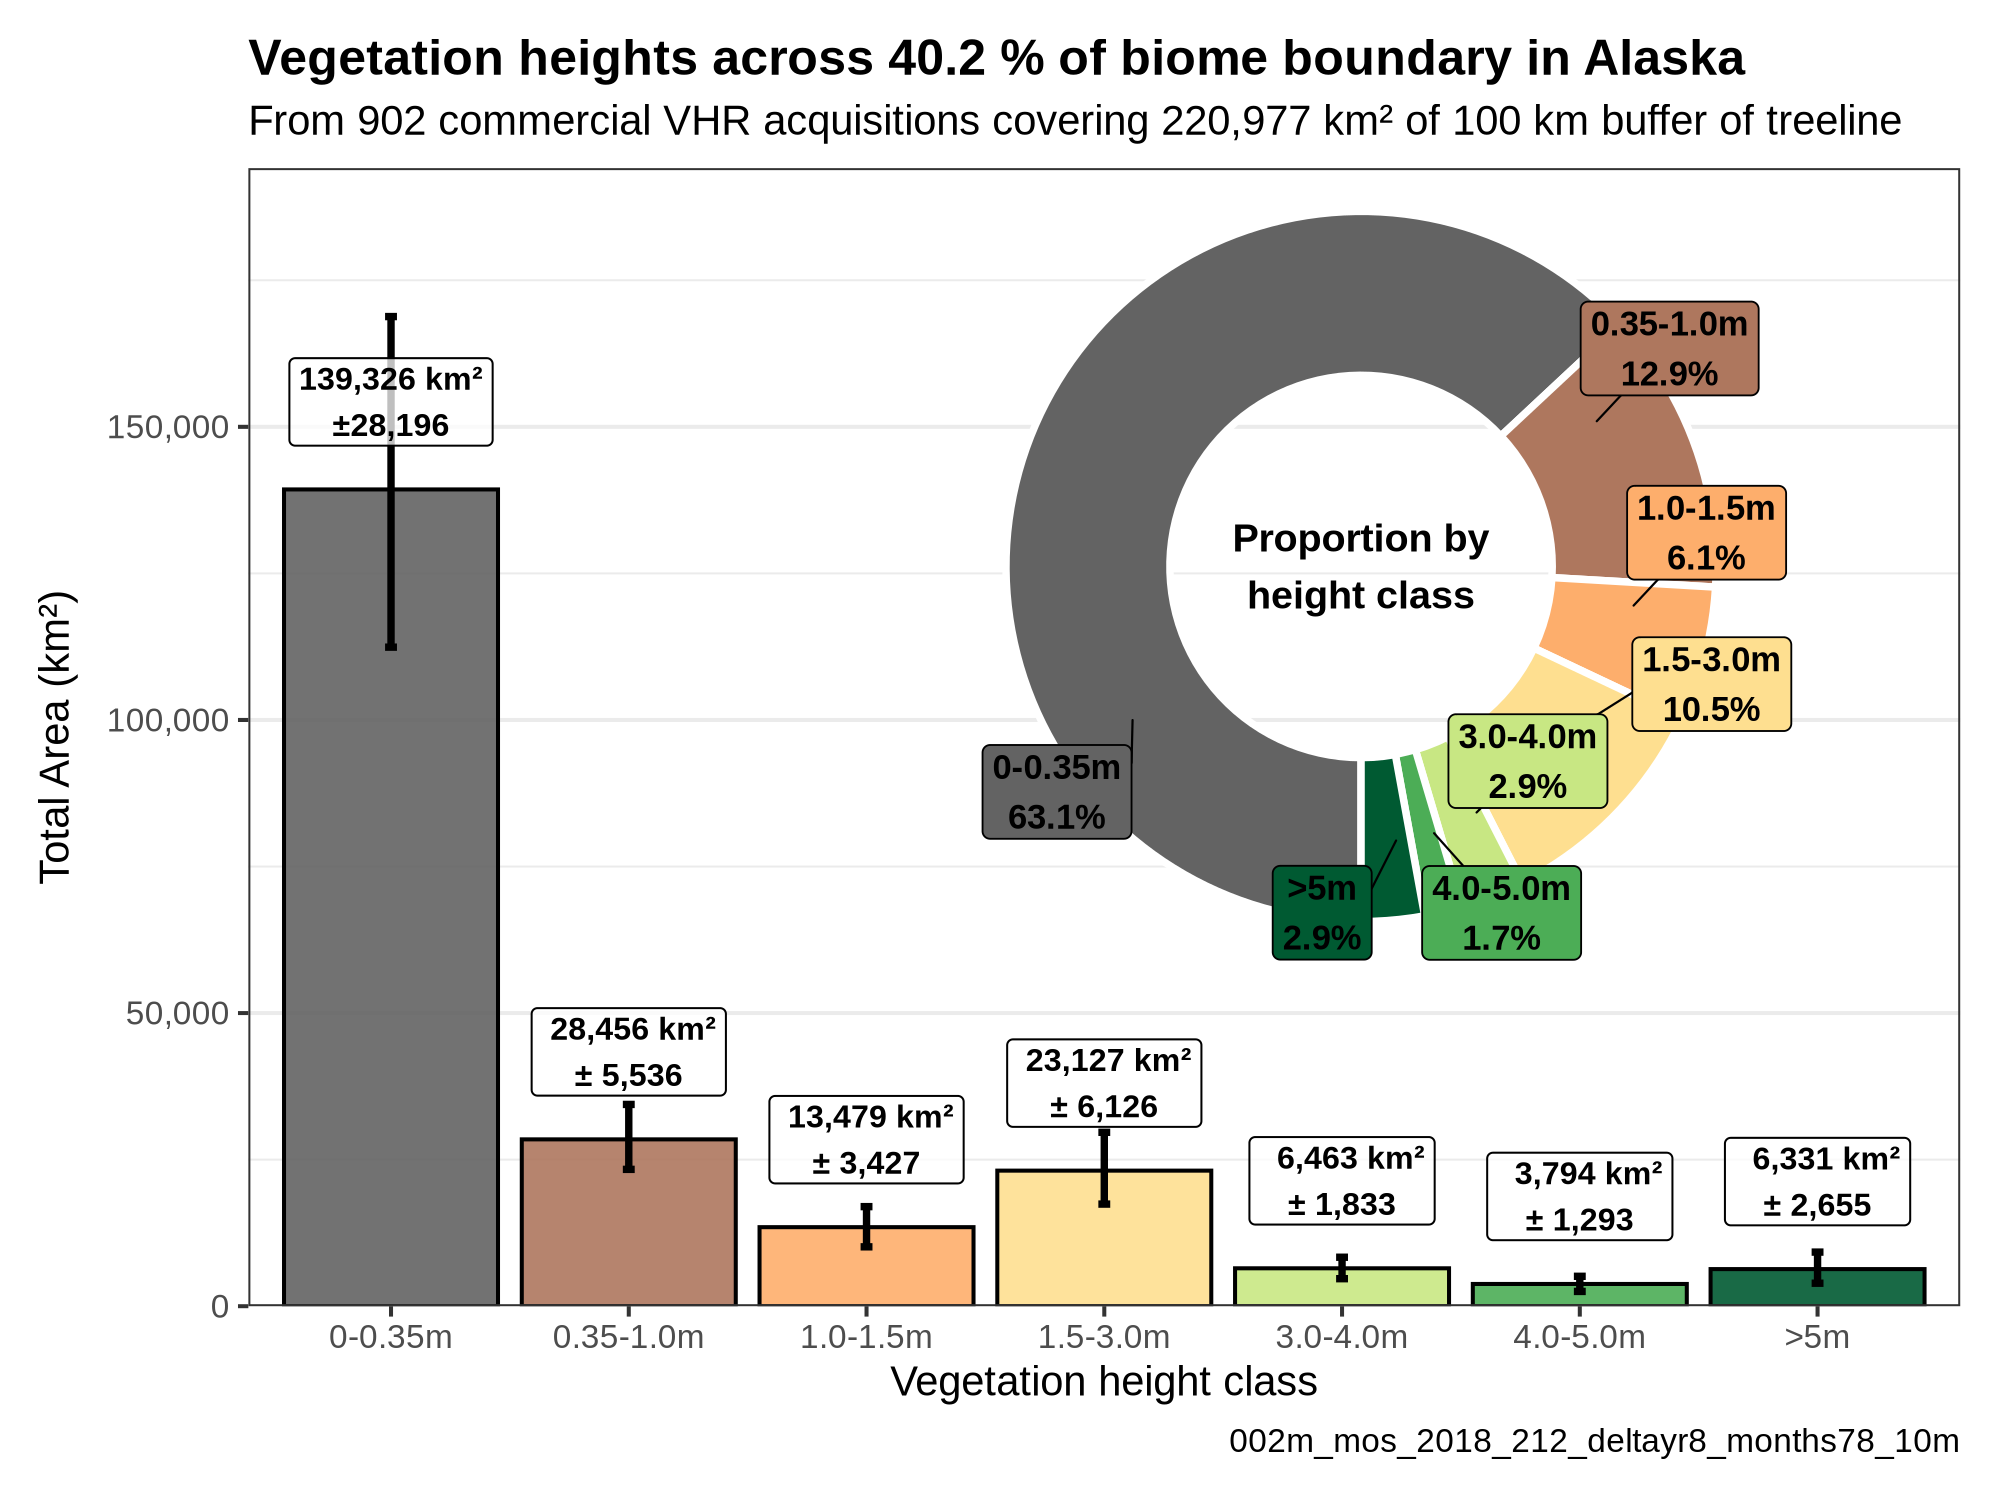

In [21]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 250, warn=-1)

NAME_STEM = 'cavm100km_alaska_chm_002m'

MAINDIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
INDIR =          paste0(MAINDIR, '/chm/2026_chm/4.3.2.5')
DIR_PAPER_FIGS = paste0(MAINDIR, '/paper_figs')
 
MOSAIC_SUBDIR_LIST = c(
    # 8 yr window - including Sept
    '002m_mos_2018_212_deltayr8_months789_10m',
    #'002m_mos_2018_212_deltayr8_months789_50m',
    # 8 yr window
    '002m_mos_2018_212_deltayr8_months78_10m' #,
    #'002m_mos_2018_212_deltayr8_months78_50m'
    # 5 yr window
    #'002m_mos_2018_212_deltayr5_months78_10m'
    #'002m_mos_2018_212_deltayr5_months78_50m',
    #'002m_mos_2018_212_deltayr5_months78_75m'
)

for(MOSAIC_SUBDIR in MOSAIC_SUBDIR_LIST){
    print(MOSAIC_SUBDIR)
    area_stats <- fread(paste0(DIR_PAPER_FIGS,'/', NAME_STEM, '_height_class_area_',MOSAIC_SUBDIR,'.csv'))

    mosaic_smry <- fread(list.files(paste0(INDIR,'/',MOSAIC_SUBDIR,'/'), 
                                pattern = 'mosaic_summary_.*\\.csv$', 
                                full.names = TRUE)[1])
    
    total_chms_used = mosaic_smry$total_chms_used
    
    output = calc_area_stats(area_stats)
    area_long_combined = output[[1]]
    pct_AOI_mapped = output[[2]]

    area_summary = do_bootstrap_ci(area_long_combined) %>%
        mutate(
            height_for_color = pmin(height_lower_combined, 5)
            )
    
    # Export summary table
    print(dim(area_summary))
    write.csv(area_summary, paste0(DIR_PAPER_FIGS, "/", NAME_STEM, "_height_class_area_summary_",MOSAIC_SUBDIR,".csv"), row.names = FALSE)

    resulting_plots = calc_totals_and_plot(area_stats, area_summary, pct_AOI_mapped, forest_ht_colors_12, total_chms_used)
    combined = resulting_plots[[1]]
    p_bar    = resulting_plots[[2]]
    p_donut  = resulting_plots[[3]]
    
    print(combined)
    
    # Save 'combined' plot
    ggsave(paste0(DIR_PAPER_FIGS, "/p_bar_donut_", NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".png"), combined, width = 10, height = 6, dpi = 300)

    # Save indiv plot objects to file so you can put them on a map later
    saveRDS(p_bar,   paste0(DIR_PAPER_FIGS, "/p_bar_",   NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".rds"))
    saveRDS(p_donut, paste0(DIR_PAPER_FIGS, "/p_donut_", NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".rds"))
    }


In [9]:
dim(area_stats)

[1] 103  25

In [40]:
# Find which layer is geom_text
sapply(p_donut$layers, function(x) class(x$geom)[1])

[1] "GeomCol"  "GeomText" "GeomText"

In [14]:
p_donut$layer[[1]]

geom_col: just = 0.5, width = NULL, na.rm = FALSE
stat_identity: na.rm = FALSE
position_stack 

In [15]:
  # # Repelled labels for small categories
  # geom_text_repel(data = area_summary %>% filter(is_small),
  #                 aes(label = pct_label), 
  #                 position = position_stack(vjust = 0.5),
  #                 color = "black", 
  #                 fontface = "bold", 
  #                 size = 2.5,
  #                 min.segment.length = 0,
  #                 segment.color = "gray40",
  #                 nudge_x = 1.5,
  #                 direction = "both") +